<table align="center">
  <td align="center"><a target="_blank" href="https://github.com/jariasf/GMVAE/tree/master/pytorch">
        <img src="http://introtodeeplearning.com/images/colab/github.png"  height="70px" style="padding-bottom:5px;"  />
    <br>View Source on GitHub</a></td>
  
  <td align="center"><a target="_blank" href="https://colab.research.google.com/drive/173A4-xUYCVnc8nKCy1syKRJi7rw8B38V">
        <img src="https://www.gstatic.com/devrel-devsite/v741200ba74cbd1989790411f8b27fb588884a771dac0e0472d95190dde1f7e2f/tensorflow/images/lockup.svg"  height="70px" style="padding-bottom:5px;"  /><br>View TensorFlow Version</a></td>
  
</table>

# Gaussian Mixture Variational Autoencoder

**Author:** Jhosimar George Arias Figueroa

This notebook contains a pytorch implementation of a Gaussian Mixture Variational Autoencoder (GMVAE) applied to unsupervised clustering. The model is based on the M2 Unsupervised model proposed by Kingma et al. (https://arxiv.org/pdf/1406.5298), where instead of marginalization of the categorical variable, we use the Gumbel-Softmax distribution (https://arxiv.org/pdf/1611.01144) and modify the generative model to represent a Mixture of Gaussians. 

## Load Source Code from Github

In [2]:
# clone the github repository to access source code
!git clone https://github.com/jariasf/GMVAE.git

# set the correct directory
%cd GMVAE/pytorch

Cloning into 'GMVAE'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 76 (delta 0), reused 1 (delta 0), pack-reused 73
Unpacking objects: 100% (76/76), done.
/content/GMVAE/pytorch/GMVAE/pytorch


## Install Latest Version of Pytorch

In [3]:
# tested with torch-1.3.0 torchvision-0.4.1
!pip install --upgrade torch torchvision

     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:37tcmalloc: large alloc 1147494400 bytes == 0x55e2f8a48000 @  0x7fddd4e53615 0x55e2930234cc 0x55e29310347a 0x55e2930262ed 0x55e293117e1d 0x55e293099e99 0x55e2930949ee 0x55e293027bda 0x55e293099d00 0x55e2930949ee 0x55e293027bda 0x55e293096737 0x55e293118c66 0x55e293095daf 0x55e293118c66 0x55e293095daf 0x55e293118c66 0x55e293095daf 0x55e293028039 0x55e29306b409 0x55e293026c52 0x55e293099c25 0x55e2930949ee 0x55e293027bda 0x55e293096737 0x55e2930949ee 0x55e293027bda 0x55e293095915 0x55e293027afa 0x55e293095c0d 0x55e2930949ee
     |████████████████████████████████| 881.9 MB 17 kB/s 
     |████████████████████████████████| 23.3 MB 85 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.

## Import Libraries

In [4]:
import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat
from model.GMVAE import *
import matplotlib.pyplot as plt
%matplotlib inline

## Input Parameters

In [24]:
#########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=11785, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=100,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=16, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=10,
                    help='number of classes (default: 10)')
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=784, type=int,
                    help='input size (default: 784)')

## Partition parameters
parser.add_argument('--train_proportion', default=1.0, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [25]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
  torch.cuda.manual_seed(SEED)

## MNIST Dataset

The MNIST dataset consists of 70000 handwritten digits of 28×28 pixel size and 10 classes, of which 60000 images are considered for training and 10000 images for testing. This dataset can be obtained directly from the [torchvision](https://pytorch.org/docs/stable/torchvision/datasets.html) framework.

In [7]:
print("Loading mnist dataset...")

# load mnist data
train_dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor())

# print dataset shape
print('Train size: ', len(train_dataset), ' Test size: ', len(test_dataset))

Loading mnist dataset...


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Train size:  60000  Test size:  10000


Let's visualize what the training data looks like:

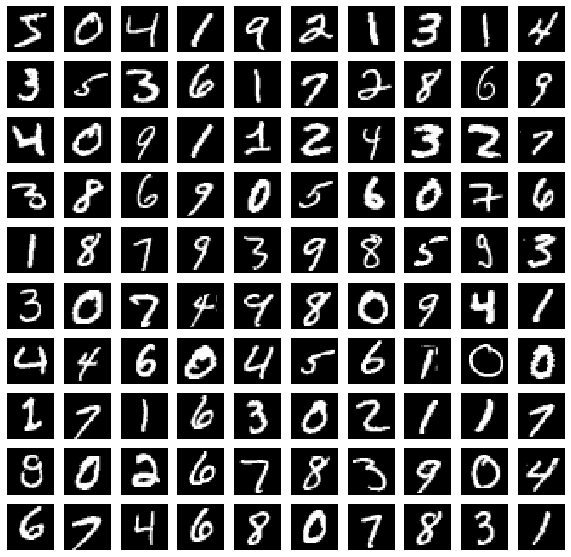

In [8]:
plt.figure(figsize=[10,10])
for i in range(0,100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(train_dataset[i][0], (28,28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [9]:
def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices

if args.train_proportion == 1.0: 
  # we use all train dataset without partitioning
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)
  val_loader = test_loader
else:
  # partition dataset according to train_proportion
  train_indices, val_indices = partition_dataset(len(train_dataset), args.train_proportion)
  # create data loaders for train, validation and test datasets
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
  val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)


## Train Model

In [29]:
# Model Initialization
args.learning_rate = 0.0005
# args.gaussian_size = 200
gmvae = GMVAE(args)

In [33]:
checkpoint = torch.load('gmvae_model_150_epochs.pth')
gmvae.network.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
accuracy = checkpoint['accuracy']
nmi = checkpoint['nmi']
print ("Accuracy: ", accuracy)
print ("NMI: ", nmi)
print ("epoch: ", epoch)

Accuracy:  82.88
NMI:  81.56191294533515
epoch:  150


In [31]:
# Training Phase
history_loss = gmvae.train(train_loader, val_loader)

(Epoch 1 / 100) Train_Loss: 106.770; Val_Loss: 111.081   Train_ACC: 82.640; Val_ACC: 82.560   Train_NMI: 81.172; Val_NMI: 81.011
(Epoch 2 / 100) Train_Loss: 106.786; Val_Loss: 111.100   Train_ACC: 82.652; Val_ACC: 82.680   Train_NMI: 81.122; Val_NMI: 80.973
(Epoch 3 / 100) Train_Loss: 106.759; Val_Loss: 111.044   Train_ACC: 82.598; Val_ACC: 82.640   Train_NMI: 81.059; Val_NMI: 80.857
(Epoch 4 / 100) Train_Loss: 106.735; Val_Loss: 111.102   Train_ACC: 82.648; Val_ACC: 82.650   Train_NMI: 81.032; Val_NMI: 81.013
(Epoch 5 / 100) Train_Loss: 106.774; Val_Loss: 110.989   Train_ACC: 82.635; Val_ACC: 82.400   Train_NMI: 81.035; Val_NMI: 80.597
(Epoch 6 / 100) Train_Loss: 106.757; Val_Loss: 111.130   Train_ACC: 82.625; Val_ACC: 82.550   Train_NMI: 80.936; Val_NMI: 80.677
(Epoch 7 / 100) Train_Loss: 106.738; Val_Loss: 111.154   Train_ACC: 82.575; Val_ACC: 82.660   Train_NMI: 80.919; Val_NMI: 80.927
(Epoch 8 / 100) Train_Loss: 106.759; Val_Loss: 111.051   Train_ACC: 82.677; Val_ACC: 82.410   Tra

KeyboardInterrupt: ignored

## Test Data

In [34]:
accuracy, nmi = gmvae.test(test_loader)

print("Testing phase...")
print("Accuracy: %.5lf,  NMI: %.5lf" % (accuracy, nmi) )

Testing phase...
Accuracy: 82.88000,  NMI: 81.56191


In [35]:
!pwd

/content/GMVAE/pytorch/GMVAE/pytorch


In [19]:
# Saving the model 
torch.save({
            'epoch': 150,
            'model_state_dict': gmvae.network.state_dict(),
            'accuracy': accuracy, 
            'nmi': nmi
            }, 'gmvae_model_150_epochs.pth')

## Image Reconstruction

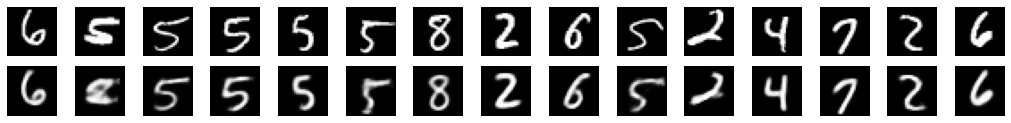

In [36]:
def display_reconstructed(original, reconstructed, n=10):
  plt.figure(figsize=[18,2])
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    if reconstructed is not None:
      plt.subplot(2, n, i + n + 1)
      plt.imshow(reconstructed[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

original, reconstructed = gmvae.reconstruct_data(test_loader, 15)  
display_reconstructed(original, reconstructed, 15)

## Random Generation per Category

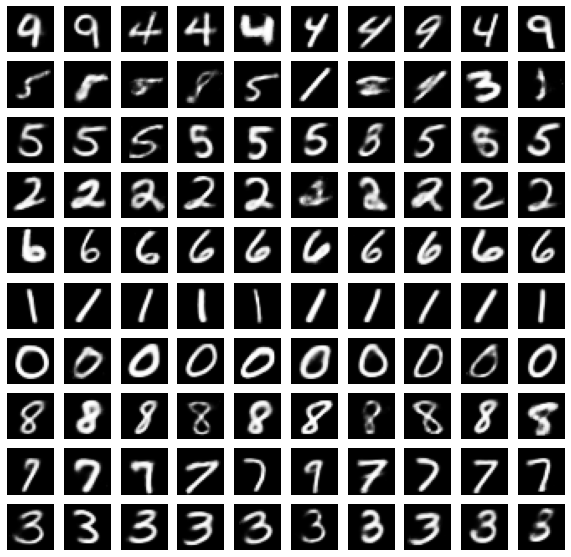

In [39]:
def display_random_generation(generated, num_classes, n=10):
  plt.figure(figsize=[10,10])
  for c in range(num_classes):
    for i in range(n):
      plt.subplot(num_classes, n, (c * n) + i + 1)
      plt.imshow(generated[(c * n) + i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

elem_per_category = 10
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

## Visualization of the feature latent space

In [40]:
# get feature representations
test_features, test_labels = gmvae.latent_features(test_loader, True)

In [41]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm
tsne_features = TSNE(n_components=2).fit_transform(test_features[:1000,])

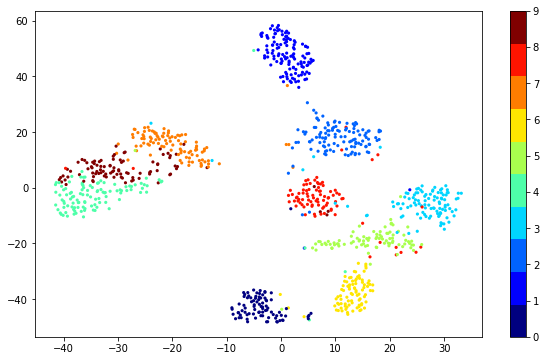

In [43]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
# plt.axis('off')
plt.colorbar()